In [1]:
import os
import pandas
import pandas_gbq
import unidecode

from google.cloud import bigquery


In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/Users/5danalfaro/OAN/credentials/nikaritcloud-05c476a4efcd.json'

In [3]:
client = bigquery.Client()

In [4]:
query_job = client.query("""
    SELECT
      CONCAT(
        'https://stackoverflow.com/questions/',
        CAST(id as STRING)) as url,
      view_count
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE tags like '%google-bigquery%'
    ORDER BY view_count DESC
    LIMIT 10""")

results = query_job.result()  # Waits for job to complete.

In [5]:
query_job.to_dataframe()

,url,view_count
0,https://stackoverflow.com/questions/22879669,52306
1,https://stackoverflow.com/questions/13530967,46073
2,https://stackoverflow.com/questions/35159967,45991
3,https://stackoverflow.com/questions/10604135,45238
4,https://stackoverflow.com/questions/16609219,37758
5,https://stackoverflow.com/questions/11647201,32963
6,https://stackoverflow.com/questions/13221978,32507
7,https://stackoverflow.com/questions/27060396,31630
8,https://stackoverflow.com/questions/6607552,31487
9,https://stackoverflow.com/questions/11057219,29069


# LIST DATASETS

In [6]:
datasets = list(client.list_datasets())
project = client.project

if datasets:
    print("Datasets in project {}:".format(project))
    for dataset in datasets:  # API request(s)
        print("\t{}".format(dataset.dataset_id))
else:
    print("{} project does not contain any datasets.".format(project))

Datasets in project nikaritcloud:
	clients_test


# CREATE A DATASET

In [4]:
# TODO(developer): Set dataset_id to the ID of the dataset to create.
dataset_id = "{}.shopify_clients".format(client.project)

In [5]:
# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_id)

# TODO(developer): Specify the geographic location where the dataset should reside.
dataset.location = "EU"

# Send the dataset to the API for creation.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
dataset = client.create_dataset(dataset)  # API request
print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

Created dataset nikaritcloud.shopify_clients


In [6]:
"{}.{}".format(client.project, dataset.dataset_id)

'nikaritcloud.shopify_clients'

In [17]:
schema = [
    bigquery.SchemaField("full_name", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("age", "INTEGER", mode="REQUIRED"),
]

# TODO(developer): Construct a BigQuery client object.
# client = bigquery.Client()

# TODO(developer): Set table_id to the ID of the table to create
table_id = "{}.{}.clients_test_sells".format(client.project, dataset.dataset_id)

table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # API request
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table nikaritcloud.clients_test.clients_test_sells


## FROM PANDAS

In [29]:
# TODO: Set project_id to your Google Cloud Platform project ID.
# project_id = "my-project"

# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = "{}.clients_test_sells".format(dataset.dataset_id)

df = pandas.DataFrame(
    {
        "full_name": ["a", "b", "c"],
        "age": [1, 2, 3]
    }
)

pandas_gbq.to_gbq(df, table_id, project_id=client.project, if_exists='replace')


0it [00:00, ?it/s]
1it [00:13, 13.09s/it]

In [27]:
df

,name,age
0,a,1
1,b,2
2,c,3


## FROM URI

In [ ]:
dataset_ref = client.dataset(dataset_id)
job_config = bigquery.LoadJobConfig()
job_config.schema = [
    bigquery.SchemaField("name", "STRING"),
    bigquery.SchemaField("post_abbr", "STRING"),
]
job_config.source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON
uri = "gs://cloud-samples-data/bigquery/us-states/us-states.json"

load_job = client.load_table_from_uri(
    uri,
    dataset_ref.table("us_states"),
    location="US",  # Location must match that of the destination dataset.
    job_config=job_config,
)  # API request
print("Starting job {}".format(load_job.job_id))

load_job.result()  # Waits for table load to complete.
print("Job finished.")

destination_table = client.get_table(dataset_ref.table("us_states"))
print("Loaded {} rows.".format(destination_table.num_rows))

## GET DATA FROM SHOPIFY

In [8]:
# Imports
import pandas as pd
import numpy as np
import requests
import yaml
import json
import shopify
import matplotlib
import matplotlib.pyplot as plt
import datetime

# Load connections parameters:
with open("/Users/5danalfaro/OAN/credentials/shopify/parameters.yaml", "r") as params:
    f = yaml.load(params, Loader=yaml.FullLoader)
    base_url = f['base_url']
    nikarit_url = f['shop_url']
    API_KEY = f['API_KEY']
    PASSWORD = f['PASSWORD']
    SHARED_SECRET = f['SHARED_SECRET']
    shop_url = f['ACCESS_URL']
    base_url2 = ' https://'+ base_url


In [9]:
def get_all_products():

    r = requests.get(
    shop_url+"/products.json")

    return r.json()

def get_all_customers(limit):

    r = requests.get(
    shop_url+"/customers.json",
    params={
        'limit':limit
        
    })

    return r.json()

def get_all_orders(limit,status='any'):

    r = requests.get(
    shop_url+"/orders.json",
    params={
        'limit':limit,
        'status':status
    })

    return r.json()

# WOMEN AND MEN NAMES

In [10]:
url = 'https://raw.githubusercontent.com/marcboquet/spanish-names/master/mujeres.csv'
df_mujeres = pd.read_csv(url, error_bad_lines=False)
l_mujeres = df_mujeres['nombre'].to_list()

In [11]:
l_mujeres = [str(nom).lower() for nom in l_mujeres]

In [12]:
url = 'https://raw.githubusercontent.com/marcboquet/spanish-names/master/hombres.csv'
df_hombres = pd.read_csv(url, error_bad_lines=False)
l_hombres = df_hombres['nombre'].to_list()

In [13]:
l_hombres = [nom.lower() for nom in l_hombres]

# GET ALL ORDERS

In [14]:
all_orders= get_all_orders(250)

In [15]:
df_orders = pd.DataFrame(all_orders['orders']) 

In [16]:
import datetime

In [32]:
df_orders['fecha']= df_orders.created_at.apply(
    lambda x: datetime.datetime.strptime(x.split('+')[0], '%Y-%m-%dT%H:%M:%S'))

In [61]:
df_sells=df_orders[['fecha','total_price','email','billing_address','line_items','shipping_address']].copy()

In [70]:
df_sells['name']=df_sells.apply(lambda x: 
                    x['billing_address']['first_name']+' '+
                    x['billing_address']['last_name'],axis=1)

In [71]:
df_sells['poblacion']=df_sells['shipping_address'].apply(lambda x: x['city'])

In [72]:
df_sells['latitude']=df_sells['shipping_address'].apply(lambda x: x['latitude'])

In [73]:
df_sells['longitude']=df_sells['shipping_address'].apply(lambda x: x['longitude'])

In [74]:
def countproducts(x):
    products=x['line_items']
    manteca =0
    crema = 0
    balsamo = 0
    products_dict = {'01':(1,0,0),
                     '02':(0,1,0),
                     '03':(0,0,1),
                     '04':(1,1,0),
                     '05':(1,1,1),
                     '06':(20,0,0)
                    }
    for prod in products:
        prod_id =prod['name'][0:2]
        quant=int(prod['quantity'])
        manteca += products_dict[prod_id][0]*quant
        crema += products_dict[prod_id][1]*quant
        balsamo += products_dict[prod_id][2]*quant
        
    return pd.Series([manteca,crema,balsamo])

In [75]:
df_sells[['mantecas','cremas','balsamos']]=df_sells.apply(lambda x: countproducts(x),axis =1)

In [76]:
df_sells['sex'] = df_sells.apply(lambda x: 
                            'F' if unidecode.unidecode(
                                    str(x['billing_address']['first_name']).lower()) in l_mujeres
                            else 'M' if unidecode.unidecode(
                                str(x['billing_address']['first_name']).lower())  in l_hombres
                            else 'N/A' , axis =1)

In [77]:
df_sells.total_price=df_sells.total_price.map(float)

In [78]:
df_sells = df_sells[['fecha','total_price','name','sex','email',
                     'mantecas','cremas','balsamos',
                     'poblacion','latitude','longitude']]

## upload to BIGQUERY

In [80]:
df_sells.dtypes

fecha          datetime64[ns]
total_price           float64
name                   object
sex                    object
email                  object
mantecas                int64
cremas                  int64
balsamos                int64
poblacion              object
latitude              float64
longitude             float64
dtype: object

In [81]:
table_id = "{}.clients_main_info".format(dataset.dataset_id)

pandas_gbq.to_gbq(df_sells, table_id, project_id=client.project, if_exists='replace')

1it [00:03,  3.49s/it]


# LETS DO SIMPLE ANALYSIS

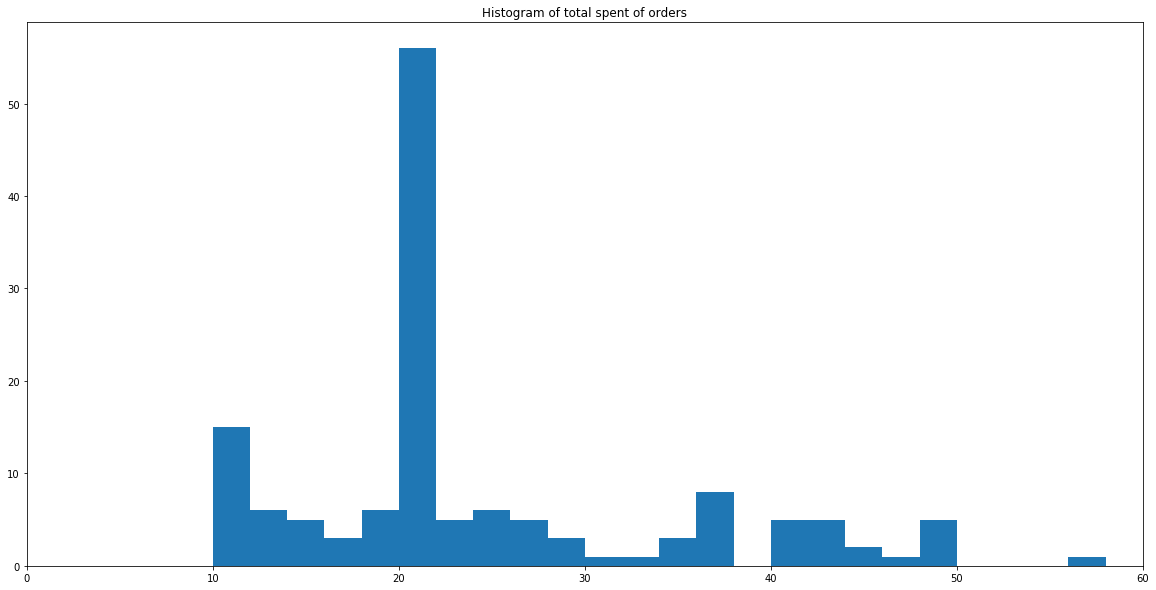

In [271]:
fig, ax = plt.subplots(figsize=(20,10))

x = np.array(df_sells['total_price'].map(float).to_list())

ax.hist(x, bins=[a*2 for a in range(30)])

ax.set_xlim(0,60)

plt.title('Histogram of total spent of orders')
plt.show()


# get data from customers

In [272]:
all_customers = get_all_customers(250)

In [273]:
df_customers = pd.DataFrame(all_customers['customers']) 

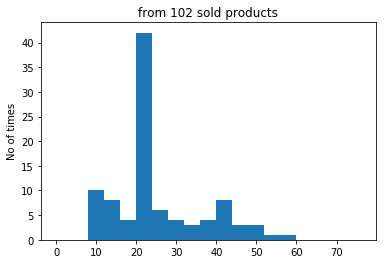

In [274]:
x = np.array(df_customers[df_customers['total_spent'].astype(float) > 0]['total_spent'].astype(float))
plt.hist(x, bins=[a*4 for a in range(20)])
plt.ylabel('No of times')
plt.title('from '+str(len(x))+' sold products')
plt.show()

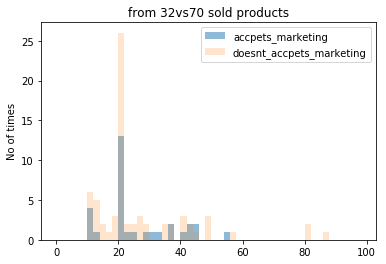

In [275]:
df_sells_cus = df_customers[df_customers['total_spent'].astype(float) > 0]
df_sells_accepts=df_sells_cus[df_sells_cus['accepts_marketing']==True]
df_sells_notaccepts=df_sells_cus[df_sells_cus['accepts_marketing']==False]
x = df_sells_accepts['total_spent'].astype(float)
y = df_sells_notaccepts['total_spent'].astype(float)

bins=[a*2 for a in range(50)]

plt.hist(x, bins, alpha=0.5, label='accpets_marketing')
plt.hist(y, bins, alpha=0.2, label='doesnt_accpets_marketing')
plt.legend(loc='upper right')

plt.ylabel('No of times')
plt.title('from '+str(len(x))+'vs'+str(len(y))+' sold products')
plt.show()


In [183]:
df_customers['sex'] = df_customers.apply(lambda x: 
                            'F' if unidecode.unidecode(str(x['first_name']).lower()) in l_mujeres
                            else 'M' if unidecode.unidecode(str(x['first_name']).lower())  in l_hombres
                            else 'N/A' , axis =1)

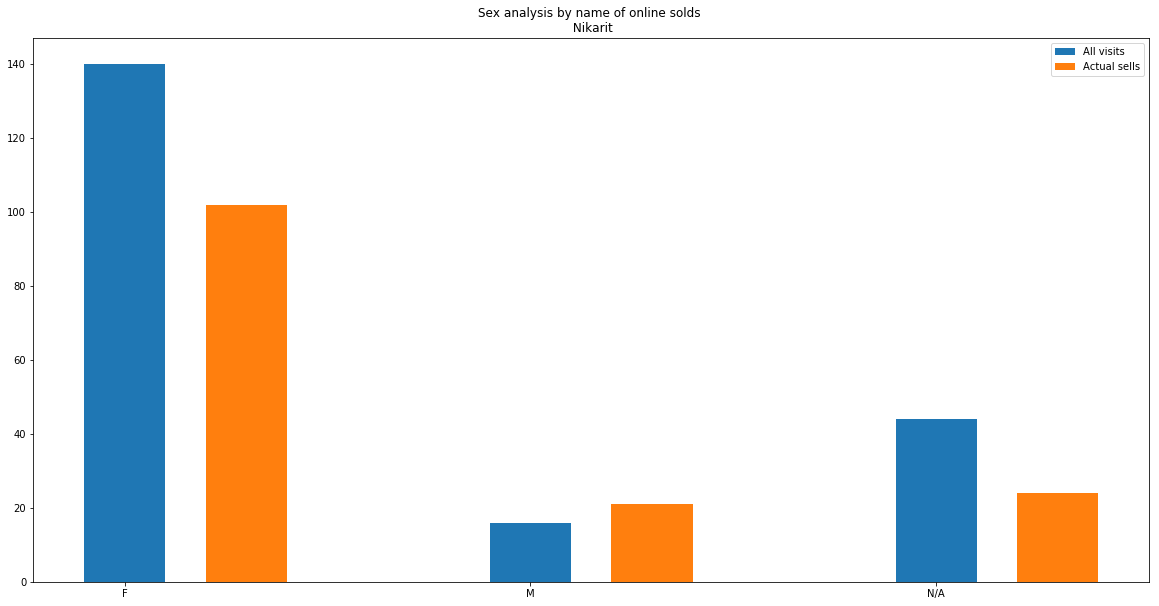

In [246]:
fig, ax = plt.subplots(figsize=(20,10))

list_sex = list(df_customers['sex'].unique())
x = [0,1,2]
x_2 = [a+0.3 for a in x]

y = [list(df_customers['sex']).count(a) for a in list_sex]

y_2 = [list(df_sells['sex']).count(a) for a in list_sex]

ax.bar(x,y,0.2,label='All visits')

ax.bar(x_2,y_2,0.2,label='Actual sells')

ax.set_xticks(x)
ax.set_xticklabels(list_sex)

plt.title('Sex analysis by name of online solds \n Nikarit')

plt.legend()
plt.show()